# Transformer and Language Model from Scratch

This project builds the **Transformer** architecture from scratch in PyTorch: self-attention, positional encoding, and full encoder/decoder. It also includes a small CNN on CIFAR-10 and a **GPT-style decoder-only** language model for text generation.

**Contents:**
- CIFAR-10 CNN (MLP, then Conv + pooling)
- Scaled dot-product attention, multi-head attention
- Positional encoding, encoder/decoder blocks
- Encoder-based classifier and GPT-like text generation


---
# Imports and Setup

First, let's import the necessary libraries. We will be using **PyTorch** for all model components.


In [2]:
import torch
import torch.nn as nn
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
from tqdm import tqdm
from collections import Counter
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, Dataset
import torch.nn.functional as F
import math
from typing import List, Tuple
device = 'cuda' if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cuda device


# Module 1: Convolutional Neural Network


## Load the dataset


In [3]:
!mkdir data
!gdown 104f_mqZiX3zCvXtvWAwtHwOD4s1vWeu1 -O data/train_cifar10.npz --quiet
!gdown 1VCY27iDzVPL-PUCTwxbkiZQy8G7Na_vU -O data/test_cifar10.npz --quiet


We use PyTorch’s dataset/dataloader framework, which is the standard way to load data efficiently for neural network training.


In [4]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

class CIFAR10NPZ(Dataset):
    """
    A custom PyTorch Dataset for loading CIFAR-10 data from NPZ files.
    It handles image loading, optional labels, and image transformations.
    """
    def __init__(self, npz_path, has_labels=True, transform=None):
        """
        Initializes the dataset.

        Args:
            npz_path (str): Path to the .npz file containing images and optionally labels.
            has_labels (bool): Whether the dataset contains labels (True for train, False for test).
            transform (callable, optional): A function/transform to apply to the images.
        """
        data = np.load(npz_path)
        self.images = data["images"]          # (N, 32, 32, 3), uint8
        self.labels = data["labels"] if has_labels else None
        self.transform = transform

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.images)

    def __getitem__(self, idx):
        """
        Retrieves a sample (image and its label/index) from the dataset at the given index.

        Args:
            idx (int): The index of the item to retrieve.

        Returns:
            tuple: A tuple containing the image (transformed) and its label (or original index).
        """
        img = self.images[idx]               # HWC, uint8
        img = Image.fromarray(img)           # convert to PIL

        if self.transform is not None:
            img = self.transform(img)

        if self.labels is None:
            return img, idx                  # for test set we return index as "id"
        else:
            label = int(self.labels[idx])
            return img, label

# Define the image transformations
transform = transforms.Compose([
    transforms.ToTensor(),       # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255]
                                 # to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
    transforms.Normalize((0.5, 0.5, 0.5), # Normalizes a tensor image with mean and standard deviation.
                         (0.5, 0.5, 0.5)),# For CIFAR-10, mean and std are often set to 0.5 for all channels
                                 # to scale pixel values from [0, 1] to [-1, 1].
])

train_dataset = CIFAR10NPZ("data/train_cifar10.npz", has_labels=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,  num_workers=2)


In [5]:
def imshow(img, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), title=None):
    """
    Display a single image or a batch of images.

    Args:
        img: Tensor or numpy array.
             Shape can be:
                CHW  (3x32x32)
                HWC  (32x32x3)
                BCHW (B,3,32,32) -> only first image shown
        mean, std: for unnormalizing standardized images
        title: optional string for the plot
    """
    # Convert tensor -> numpy
    if torch.is_tensor(img):
        img = img.detach().cpu()

    # If batch, take the first image
    if img.ndim == 4:
        img = img[0]  # BCHW -> CHW

    # If CHW, convert to HWC
    if img.ndim == 3 and img.shape[0] in (1, 3):
        img = img.permute(1, 2, 0)  # CHW -> HWC

    # Convert to numpy
    img = img.numpy()

    # Unnormalize: x = x * std + mean
    mean = np.array(mean).reshape(1, 1, 3)
    std = np.array(std).reshape(1, 1, 3)
    img = img * std + mean
    img = np.clip(img, 0, 1)

    # Plot
    plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()


Training set size: 50000


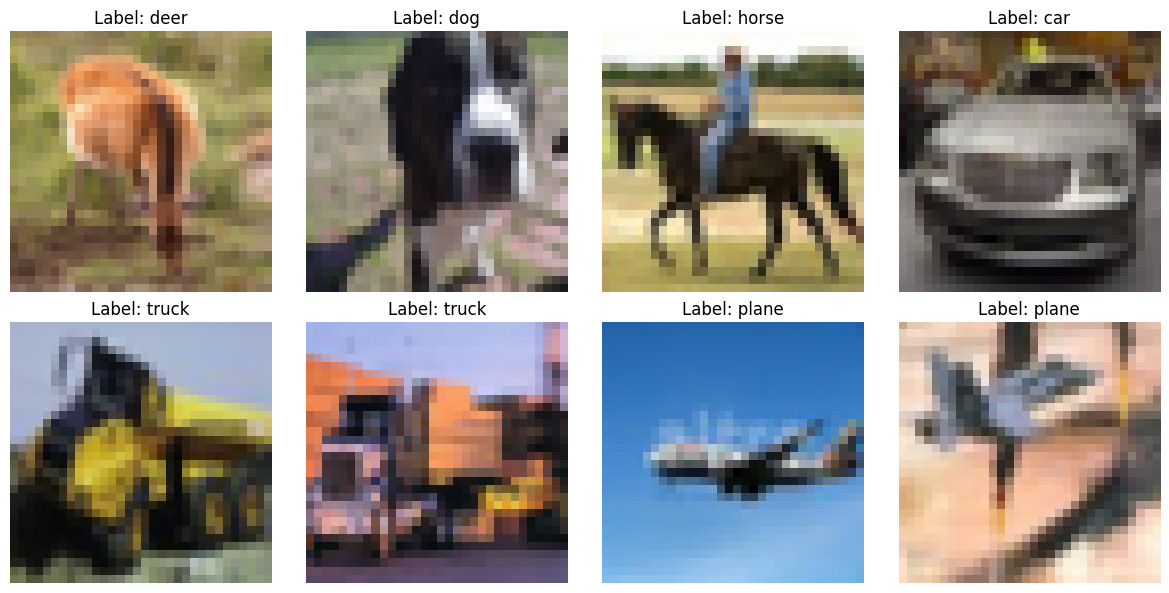

In [6]:

# Use a subset of training data for demo (5000 samples for training, 1000 for validation)
train_size = 5000
val_size = 1000
indices = list(range(len(train_dataset)))
np.random.shuffle(indices)
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]

trainset_subset = torch.utils.data.Subset(train_dataset, train_indices)
valset = torch.utils.data.Subset(train_dataset, val_indices)

trainloader = DataLoader(trainset_subset, batch_size=64, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=2)
# CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Training set size: {len(train_dataset)}")

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for idx in range(8):
    ax = axes[idx // 4, idx % 4]
    img = trainset_subset[idx][0] / 2 + 0.5  # unnormalize
    label = trainset_subset[idx][1]
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.set_title(f'Label: {classes[label]}')
    ax.axis('off')
plt.tight_layout()
plt.show()



## First Neural Network

Let us begin by implementing a neural network similar to the one used in HW8. However, this time we will build it using PyTorch’s native nn.Module instead of our own custom implementation.

`__init__` implments the model architecture.

`forward` implements the computation of logits for each class.

`predict` implement the prediction of class based on the logits.


In [11]:
class MLP_Classifier(nn.Module):
    def __init__(self, input_shape, output_dim):
        super().__init__()
        # Calculate the flattened input size from input_shape (C, H, W)
        # For CIFAR-10: (3, 32, 32) -> 3 * 32 * 32 = 3072
        input_size = input_shape[0] * input_shape[1] * input_shape[2]

        self.flatten = nn.Flatten()
        ### Write a 3-layer net, Linear(Input Size, 512) -> ReLU -> Dropout -> Linear(512, 512) -> ReLU -> Dropout -> Linear(512, output_dim)
        """
        It should look like something like this:
        self.net = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            ...
        )
        """
        self.net = nn.Sequential(nn.Linear(input_size, 512), nn.ReLU(), nn.Dropout(0.2),
                                 nn.Linear(512, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, output_dim))

    def forward(self, x):
        # Flatten the input images from (batch, C, H, W) to (batch, C*H*W)
        x = self.flatten(x)
        return self.net(x)

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            logits = self.forward(x)
            return logits.argmax(dim=-1)


## Logistic Loss → Cross Entropy Loss

In this part, we connect the **logistic loss** you already know to the **cross entropy loss** used for multi-class classification and language modeling.

---

### 1. Review: Logistic Loss for Binary Classification

In binary classification we have two classes, usually encoded as  
$$y \in \{0,1\}.$$

A logistic regression model outputs a probability
$$
\hat{p} = \sigma(z) = \frac{1}{1 + e^{-z}}, \quad z = w^\top x,
$$
where:

- \(x\) is the input feature vector,
- \(w\) are the model parameters,
- \(\hat{p}\) is the model’s estimate of \(\mathbb{P}(y=1 \mid x)\).

The **logistic loss** for one sample is
$$
\ell_{\text{logistic}}(y, \hat{p}) = -\Big( y \log \hat{p} + (1 - y)\log(1 - \hat{p}) \Big).
$$

This can be seen as the **negative log-likelihood** of the correct label under a Bernoulli distribution with parameter \(\hat{p}\).

---

### 2. From Binary to Multi-Class: Softmax Logistic Loss

Now consider a **multi-class** classification problem with \(C\) classes:
$$
y \in \{1, 2, \dots, C\}.
$$

The model outputs a **score** for each class \(c\):
$$
z_c = w_c^\top x, \quad c = 1,\dots,C.
$$

We convert these scores to a probability distribution over classes using the **softmax**:
$$
\hat{p}_c = \frac{\exp(z_c)}{\sum_{k=1}^C \exp(z_k)}, \quad c = 1,\dots,C.
$$

This is just the multi-class analog of the sigmoid:
- sigmoid normalizes two scores into a Bernoulli probability,
- softmax normalizes \(C\) scores into a categorical probability distribution.

The **multi-class logistic loss** (for one sample) is then the negative log-likelihood of the correct class:
$$
\ell_{\text{multi-logistic}}(y, \hat{\mathbf{p}})
= - \log \hat{p}_{y},
$$
where \(\hat{p}_y\) is the predicted probability of the true class \(y\).

If we represent the label as a one-hot vector
$$
\mathbf{y} = (y_1, \dots, y_C), \quad y_c \in \{0,1\}, \ \sum_{c=1}^C y_c = 1,
$$
then this loss can also be written as
$$
\ell_{\text{multi-logistic}}(\mathbf{y}, \hat{\mathbf{p}})
= -\sum_{c=1}^C y_c \log \hat{p}_c,
$$
which is exactly the **cross entropy** between the true distribution \(\mathbf{y}\) and the predicted distribution \(\hat{\mathbf{p}}\).

So:
- **logistic loss (binary)** is a special case of cross entropy with \(C=2\),
- **softmax logistic loss (multi-class)** is cross entropy for \(C>2\).

---

### 3. Cross Entropy in PyTorch (`nn.CrossEntropyLoss`)

In a neural network, we usually don’t compute \(\hat{\mathbf{p}}\) explicitly.  
Instead, the network outputs **logits**:
$$
x_{n,c} \in \mathbb{R}, \quad n = 1,\dots,N,\ c = 1,\dots,C,
$$
where \(x_{n,c}\) is the score for class \(c\) on sample \(n\).

The probabilities are defined (conceptually) using softmax:
$$
\hat{p}_{n,c}
= \frac{\exp(x_{n,c})}{\sum_{k=1}^C \exp(x_{n,k})}.
$$

The **average multi-class logistic (cross entropy) loss** over a batch is:
$$
L = -\frac{1}{N} \sum_{n=1}^N \log \hat{p}_{n, y_n}
= -\frac{1}{N} \sum_{n=1}^N
\log \left(
\frac{\exp(x_{n, y_n})}{\sum_{c=1}^C \exp(x_{n,c})}
\right).
$$

PyTorch’s `nn.CrossEntropyLoss` implements **exactly this loss** in a numerically stable way:

- **Input**: logits `x` of shape `(N, C)`  
- **Target**: integer labels `y` of shape `(N,)`, where `y[n]` is the correct class index

Example:
```python
criterion = nn.CrossEntropyLoss()
logits = model(inputs)          # shape: (N, C)
loss = criterion(logits, y)     # y: shape (N,)


Here is the training code we provide, you can read it to better understand the training pipeline in `pytorch`


In [12]:
def train_model(
    model, trainloader, valloader, optimizer,
    num_epochs=10, every_n_epochs=1
):
    """
    Train a PyTorch model while:
      - Tracking training loss every iteration (batch)
      - Evaluating train/validation error every `every_n_epochs`
      - Keeping the best model based on validation error
    """

    criterion = nn.CrossEntropyLoss()

    # Device setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Tracking metrics
    iter_train_losses = []    # one entry per iteration
    epoch_train_errors = []   # evaluated every_n_epochs
    epoch_val_errors = []     # evaluated every_n_epochs

    best_val_error = float('inf')
    best_model_state = None

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track per-iteration training loss
            iter_train_losses.append(loss.item())

        # Evaluate every `every_n_epochs`
        if (epoch + 1) % every_n_epochs == 0:
            # Compute training error
            model.eval()
            train_correct, train_total = 0, 0
            with torch.no_grad():
                for inputs, labels in trainloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    preds = model.predict(inputs)
                    train_correct += (preds == labels).sum().item()
                    train_total += labels.size(0)
            train_error = 1 - train_correct / train_total
            epoch_train_errors.append(train_error)

            # Compute validation error
            val_correct, val_total = 0, 0
            with torch.no_grad():
                for inputs, labels in valloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    preds = model.predict(inputs)
                    val_correct += (preds == labels).sum().item()
                    val_total += labels.size(0)
            val_error = 1 - val_correct / val_total
            epoch_val_errors.append(val_error)

            print(f"[Epoch {epoch+1}/{num_epochs}] "
                  f"Train error: {train_error:.4f}, "
                  f"Val error: {val_error:.4f}")

            # Track best model (based on validation error)
            if val_error < best_val_error:
                best_val_error = val_error
                best_model_state = {k: v.cpu().clone()
                                    for k, v in model.state_dict().items()}
                print("  → Best model updated.")

    print("Training complete!")

    return {
        "iter_train_losses": iter_train_losses,
        "epoch_train_errors": epoch_train_errors,
        "epoch_val_errors": epoch_val_errors,
        "best_model_state": best_model_state,
    }


Next, let's train our MLP model and visualize the training and test error.

Initialize the class with `input_shape` and `output_dim`


[Epoch 1/10] Train error: 0.5992, Val error: 0.6410
  → Best model updated.
[Epoch 2/10] Train error: 0.5724, Val error: 0.6380
  → Best model updated.
[Epoch 3/10] Train error: 0.4874, Val error: 0.6070
  → Best model updated.
[Epoch 4/10] Train error: 0.4536, Val error: 0.5990
  → Best model updated.
[Epoch 5/10] Train error: 0.4064, Val error: 0.5810
  → Best model updated.
[Epoch 6/10] Train error: 0.3634, Val error: 0.5820
[Epoch 7/10] Train error: 0.3378, Val error: 0.5730
  → Best model updated.
[Epoch 8/10] Train error: 0.2786, Val error: 0.5410
  → Best model updated.
[Epoch 9/10] Train error: 0.2434, Val error: 0.5840
[Epoch 10/10] Train error: 0.1910, Val error: 0.5760
Training complete!


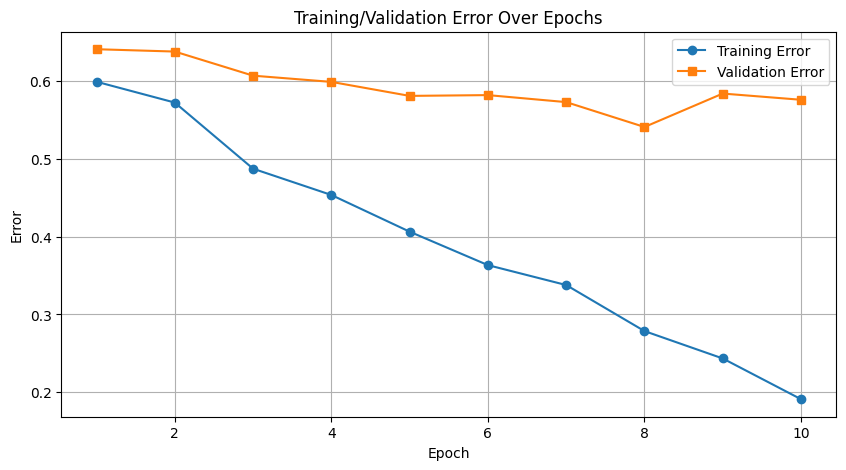

In [13]:
# Initialize the MLP model
#
input_shape = (3, 32, 32)  # CIFAR-10 image shape
output_dim = 10 # Number of classes
#

model = MLP_Classifier(input_shape, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
every_n_epochs = 1
# Train the model
results = train_model(model, trainloader, valloader,optimizer, num_epochs=10,every_n_epochs = every_n_epochs)

# Plot training and validation losses
plt.figure(figsize=(10, 5))
num_eval_points = len(results['epoch_train_errors'])
eval_epochs = [(i+1) * every_n_epochs for i in range(num_eval_points)]
plt.plot(eval_epochs, results['epoch_train_errors'], label='Training Error', marker='o')
plt.plot(eval_epochs, results['epoch_val_errors'], label='Validation Error', marker='s')

plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Training/Validation Error Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


### Computing Model Parameters

Understanding the number of parameters in a neural network is crucial for estimating memory requirements, understanding model complexity, and comparing different architectures.


Please Manually calculate the number of parameters in the MLP_Classifier we just trained.

And we will verify the results with the following function.

Hint: For each layer, count weights (input_size × output_size) and biases (output_size)



In [14]:

# Now let's verify with code:
def count_parameters(model):
    """
    Count the total number of trainable parameters in a PyTorch model.

    Args:
        model: PyTorch model

    Returns:
        total_params: Total number of trainable parameters
    """
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params

# Count parameters in our MLP model
mlp_params = count_parameters(model)
print(f"Total trainable parameters in MLP_Classifier: {mlp_params:,}")

# Let's also break it down by layer
print("\nParameter breakdown by layer:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.numel():,} parameters (shape: {list(param.shape)})")



Total trainable parameters in MLP_Classifier: 1,841,162

Parameter breakdown by layer:
net.0.weight: 1,572,864 parameters (shape: [512, 3072])
net.0.bias: 512 parameters (shape: [512])
net.3.weight: 262,144 parameters (shape: [512, 512])
net.3.bias: 512 parameters (shape: [512])
net.6.weight: 5,120 parameters (shape: [10, 512])
net.6.bias: 10 parameters (shape: [10])


## Convolutional Neural Networks

Now, let's introduce a common structure for neural networks to increase depth: Convolutional neural networks.

This is a special type of linear layer that uses less trainable parameters per layer, which allows for deeper models to be trained. A layer of the neural network will just apply a convolution to the current input to get the next stage, using a fixed kernel per channel. This dramatically decreases the number of parameters required in each layer, allowing for more and deeper layers with similar training times.

An intuition for this type of model is that a given kernel convolution isolates a certain feature in an image, so then looking for a certain feature can use the same convolution at any point.


### Convolution (Conv2d)

A convolution filter is a small “pattern detector” that slides over the image.
	•	Start from grayscale with a tiny example:
	•	5×5 image, 3×3 kernel.
	•	Show one output pixel as:
$$\text{output}[i,j] = \sum_{u,v} \text{kernel}[u,v] \cdot \text{input}[i+u, j+v]$$

This could be extended to RGB: Kernel shape: (out_channels, in_channels, kH, kW)

e.g. Conv2d(3, 32, kernel_size=3) learns 32 different 3×3×3 filters.
	•	Each filter produces one feature map.


For a 2D convolution, with input height/width $H_\text{in}, W_\text{in}$, kernel size $K_h, K_w$, padding $P_h, P_w$, stride $S_h, S_w$ and dilation $D_h, D_w$:

#### Kernel  Size

The kernel is a small matrix of learnable parameters that scans across the input.
- If the kernel size is $K_h \times K_w$, then at each spatial location the convolution computes a weighted sum over a $K_h \times K_w$ patch of the input.
- Common choices include $3 \times 3,5 \times 5$, or $7 \times 7$.

Intuition:
- The kernel defines the "local receptive field"-how much of the input is seen at once. Larger kernels capture broader spatial patterns but require more computation and parameters.

#### Padding

Padding specifies how many pixels we add around the border of the input before applying the convolution.
- $P_h=$ padding added to the top and bottom
- $P_w=$ padding added to the left and right

Typical choices include:
- padding $=0 \rightarrow$ no padding
- padding=1 for $3 \times 3$ kernels → preserves spatial size

#### Stride

The stride determines how far the kernel moves each time.
- $S_h=$ vertical stride
- $S_w=$ horizontal stride

Key effect:
- Larger strides downsample the input.
- Small strides (e.g., 1) preserve more spatial detail.

Example:
- Stride $=1 \rightarrow$ kernel slides 1 pixel each step (dense scanning).
- Stride $=2 \rightarrow$ kernel jumps 2 pixels at a time → output is roughly half the size.



#### Dilation

Dilation controls the spacing between the elements inside the kernel.
- $D_h, D_w$ specify how much to "inflate" the kernel by inserting gaps.

Dilation = 1
→ Standard contiguous kernel (e.g., a normal $3 \times 3$ convolution)

Dilation = 2
→ Inserts one zero-space between kernel elements, increasing its effective receptive field without increasing the number of parameters.



The output size of the Conv2D with input size $(H_{in},W_{in})$ and Padding $P_{h}$,$P_{w}$, Stride $P_{h}$,$P_{w}$ and Dilation $D_{h}$,$D_{w}$.


Let $K_h$ and $K_w$ are the kernel height and width

$$H_{out} = \left\lfloor \frac{H_{in} + 2P_h - D_h(K_h - 1) - 1}{S_h} + 1 \right\rfloor$$

$$W_{out} = \left\lfloor \frac{W_{in} + 2P_w - D_w(K_w - 1) - 1}{S_w} + 1 \right\rfloor$$





After writing your answer, you can complete the following code with the formula you write above.


In [15]:
def conv2d_output_size(
    H_in, W_in,
    kernel_size,
    padding=0,
    stride=1,
    dilation=1,
):
    """
    Compute output H_out, W_out for Conv2d.
    Supports int or tuple for kernel_size, padding, stride, dilation.
    """
    def _to_tuple(x):
        if isinstance(x, int):
            return (x, x)
        return x

    K_h, K_w = _to_tuple(kernel_size)
    P_h, P_w = _to_tuple(padding)
    S_h, S_w = _to_tuple(stride)
    D_h, D_w = _to_tuple(dilation)
    H_out = (H_in + 2*P_h - D_h*(K_h - 1) - 1) // S_h + 1
    W_out = (W_in + 2*P_w - D_w*(K_w - 1) - 1) // S_w + 1
    return H_out, W_out


### Verifying Against nn.Conv2d

Now, you can compare your solution with the groud truth answer.


In [16]:
# Example: CIFAR-10 image 3x32x32
C_in = 1
H_in, W_in = 32, 32

conv = nn.Conv2d(in_channels=C_in, out_channels=1,
                 kernel_size=3, padding=2, stride=2, dilation=2)

x = torch.randn(1, C_in, H_in, W_in)
y = conv(x)

print("y.shape from Conv2d:", y.shape)

H_out, W_out = conv2d_output_size(
    H_in, W_in, kernel_size=3, padding=2, stride=2, dilation=2
)
print("Output size from formula:", (H_out, W_out))


y.shape from Conv2d: torch.Size([1, 1, 16, 16])
Output size from formula: (16, 16)


### Conv2D Example

Let's look at a concrete example of `conv2d`


In [17]:
# 1-channel 5x5 "image"
img = torch.tensor([
    [1, 1, 1, 0, 0],
    [1, 1, 1, 0, 0],
    [1, 1, 1, 0, 0],
    [0, 0, 0, 2, 2],
    [0, 0, 0, 2, 2],
], dtype=torch.float32)

# 1-channel 3x3 vertical edge filter
kernel = torch.tensor([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1],
], dtype=torch.float32)

# Unfold-style manual convolution (valid, stride=1, no padding)
H_in, W_in = img.shape
K = 3
H_out = H_in - K + 1
W_out = W_in - K + 1
out = torch.zeros(H_out, W_out)

for i in range(H_out):
    for j in range(W_out):
        patch = img[i:i+K, j:j+K]
        out[i, j] = torch.sum(patch * kernel)

print("Input:")
print(img)
print("\nKernel:")
print(kernel)
print("\nOutput:")
print(out)


Input:
tensor([[1., 1., 1., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 0., 0.],
        [0., 0., 0., 2., 2.],
        [0., 0., 0., 2., 2.]])

Kernel:
tensor([[-1.,  0.,  1.],
        [-1.,  0.,  1.],
        [-1.,  0.,  1.]])

Output:
tensor([[ 0., -3., -3.],
        [ 0.,  0.,  0.],
        [ 0.,  3.,  3.]])


In [18]:
conv_manual = nn.Conv2d(1, 1, kernel_size=3, padding=0, bias=False)
with torch.no_grad():
    conv_manual.weight[:] = kernel.view(1, 1, 3, 3)

y_manual = conv_manual(img.view(1, 1, 5, 5))
print("Conv2d output:")
print(y_manual[0, 0])


Conv2d output:
tensor([[ 0., -3., -3.],
        [ 0.,  0.,  0.],
        [ 0.,  3.,  3.]], grad_fn=<SelectBackward0>)


### Pooling: MaxPool and AvgPool

Pooling layers are commonly used in convolutional neural networks to reduce the spatial resolution of feature maps while keeping the most important information. They operate similarly to convolution: a small window slides across the input, but instead of applying learnable filters, pooling performs a fixed aggregation operation.

$$
\text{MaxPool}(x) = \max_{(i,j) \in \text{window}} x_{i,j}.
$$

$$
\text{AvgPool}(x) = \frac{1}{K_h K_w} \sum_{(i,j)\in \text{window}} x_{i,j}.
$$


CIFAR-10 image shape: torch.Size([1, 3, 32, 32])


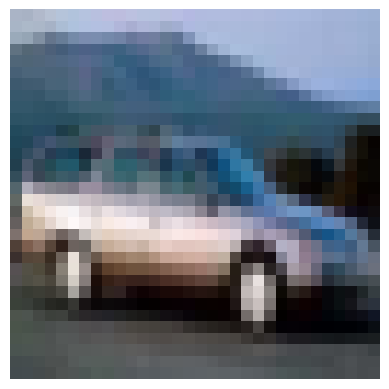


Max pooled shape: torch.Size([1, 3, 16, 16])


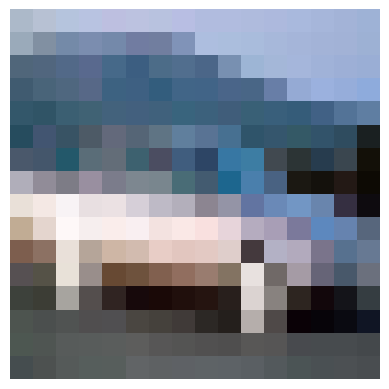

Avg pooled shape: torch.Size([1, 3, 16, 16])


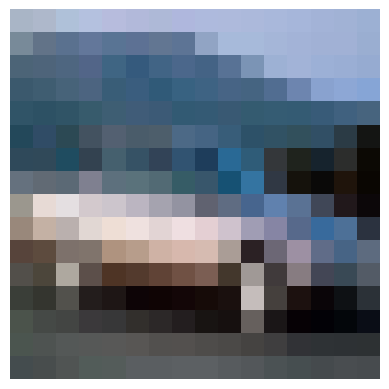

In [19]:
# Use a CIFAR-10 training image
# Get the first image from the training set
feat, label = train_dataset[4]
feat = feat.unsqueeze(0)  # Add batch dimension: (1, 3, 32, 32)

print("CIFAR-10 image shape:", feat.shape)

imshow(feat[0])


# Apply max pooling
max_pooled = F.max_pool2d(feat, kernel_size=2, stride=2)
print("\nMax pooled shape:", max_pooled.shape)

imshow(max_pooled)

# Apply average pooling
avg_pooled = F.avg_pool2d(feat, kernel_size=2, stride=2)
print("Avg pooled shape:", avg_pooled.shape)

imshow(avg_pooled)


## Put It Together

In this exercise, you will implement a small convolutional neural network (CNN) for the CIFAR-10 dataset.
The goal is to help you practice using PyTorch modules such as nn.Conv2d, nn.MaxPool2d, nn.ReLU, and fully connected layers.

`self.block1` is given; implement block2, block3, and the classifier.


In [22]:
class SimpleCIFARConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # Block 1: 3x32x32 -> 32x16x16
        self.block1 = nn.Sequential(
            #### Structure: Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d
            nn.Conv2d(3, 32, kernel_size=3, padding=1),   # Output: 32 x 32 x 32
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),  # Output: 32 x 32 x 32
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),        # Output: 32 x 16 x 16

        )

        # Block 2: 32x16x16 -> 64x8x8
        self.block2 = nn.Sequential(
            #### Structure: Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Block 3: 64x8x8 -> 128x4x4
        self.block3 = nn.Sequential(
            #### Structure: Conv2d -> ReLU -> MaxPool2d
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Fully connected classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),                                 # Flatten to 2048 = 128*4*4
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.classifier(x)
        return x

    @torch.no_grad()
    def predict(self, x):
        self.eval()
        with torch.no_grad():
            logits = self(x)
            return logits.argmax(dim=-1)


### First Convolution Example


[Epoch 1/20] Train error: 0.6856, Val error: 0.7180
  → Best model updated.
[Epoch 2/20] Train error: 0.6168, Val error: 0.6340
  → Best model updated.
[Epoch 3/20] Train error: 0.5514, Val error: 0.6080
  → Best model updated.
[Epoch 4/20] Train error: 0.4808, Val error: 0.5300
  → Best model updated.
[Epoch 5/20] Train error: 0.4330, Val error: 0.4960
  → Best model updated.
[Epoch 6/20] Train error: 0.3790, Val error: 0.4720
  → Best model updated.
[Epoch 7/20] Train error: 0.3646, Val error: 0.4570
  → Best model updated.
[Epoch 8/20] Train error: 0.2952, Val error: 0.4510
  → Best model updated.
[Epoch 9/20] Train error: 0.2468, Val error: 0.4380
  → Best model updated.
[Epoch 10/20] Train error: 0.2092, Val error: 0.4230
  → Best model updated.
[Epoch 11/20] Train error: 0.1726, Val error: 0.4500
[Epoch 12/20] Train error: 0.1026, Val error: 0.4290
[Epoch 13/20] Train error: 0.1140, Val error: 0.4570
[Epoch 14/20] Train error: 0.1026, Val error: 0.4480
[Epoch 15/20] Train error: 

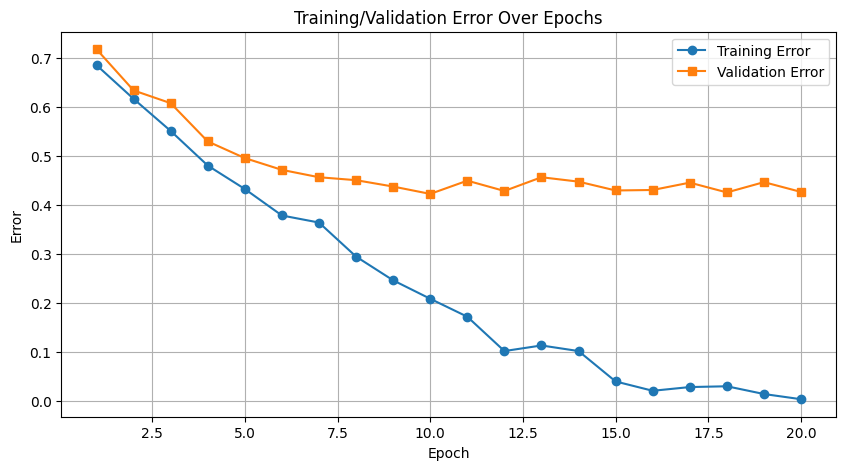

In [23]:

cnn_model = SimpleCIFARConvNet()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)
every_n_epochs = 1
results = train_model(cnn_model, trainloader, valloader,optimizer, num_epochs=20,every_n_epochs = every_n_epochs)

# Plot training and validation losses
plt.figure(figsize=(10, 5))
num_eval_points = len(results['epoch_train_errors'])
eval_epochs = [(i+1) * every_n_epochs for i in range(num_eval_points)]
plt.plot(eval_epochs, results['epoch_train_errors'], label='Training Error', marker='o')
plt.plot(eval_epochs, results['epoch_val_errors'], label='Validation Error', marker='s')

plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Training/Validation Error Over Epochs')
plt.legend()
plt.grid(True)
plt.show()



In [24]:
# Count parameters in our MLP model
cnn_params = count_parameters(cnn_model)
print(f"Total trainable parameters in CNN_Classifier: {cnn_params:,}")

# Let's also break it down by layer
print("\nParameter breakdown by layer:")
for name, param in cnn_model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.numel():,} parameters (shape: {list(param.shape)})")



Total trainable parameters in CNN_Classifier: 666,538

Parameter breakdown by layer:
block1.0.weight: 864 parameters (shape: [32, 3, 3, 3])
block1.0.bias: 32 parameters (shape: [32])
block1.2.weight: 9,216 parameters (shape: [32, 32, 3, 3])
block1.2.bias: 32 parameters (shape: [32])
block2.0.weight: 18,432 parameters (shape: [64, 32, 3, 3])
block2.0.bias: 64 parameters (shape: [64])
block2.2.weight: 36,864 parameters (shape: [64, 64, 3, 3])
block2.2.bias: 64 parameters (shape: [64])
block3.0.weight: 73,728 parameters (shape: [128, 64, 3, 3])
block3.0.bias: 128 parameters (shape: [128])
classifier.1.weight: 524,288 parameters (shape: [256, 2048])
classifier.1.bias: 256 parameters (shape: [256])
classifier.4.weight: 2,560 parameters (shape: [10, 256])
classifier.4.bias: 10 parameters (shape: [10])


## CIFAR-10 classification

Train on full data for better accuracy (takes longer). Cross-validation on learning rate, batch size, and regularization; experiment with CNN architecture.


In [20]:
test_dataset  = CIFAR10NPZ("data/test_cifar10.npz", has_labels=False, transform=transform)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False, num_workers=2)



In [21]:
# Collect predictions from CNN model
cnn_model.eval()
predictions = []
ids = []

with torch.no_grad():
    for i, (images, _) in enumerate(test_loader):
        images = images.to(device)
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        # Generate IDs for each sample
        batch_ids = list(range(i * test_loader.batch_size, i * test_loader.batch_size + len(images)))
        ids.extend(batch_ids)

# Save predictions to CSV
import pandas as pd
results_df = pd.DataFrame({
    'ID': ids,
    'label': predictions
})
results_df.to_csv('Homework_solution.csv', index=False)
print(f"Predictions saved to solution.csv with {len(predictions)} samples")




NameError: name 'cnn_model' is not defined

### Full training: complete dataset


In [ ]:
class YourModel(nn.Module):
    def __init__(self):
        super().__init__
    def forward(self, x):
        return x


predictions = []
ids = []

with torch.no_grad():
    for i, (images, _) in enumerate(test_loader):
        images = images.to(device)
        outputs = your_model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        # Generate IDs for each sample
        batch_ids = list(range(i * test_loader.batch_size, i * test_loader.batch_size + len(images)))
        ids.extend(batch_ids)

# Save predictions to CSV
import pandas as pd
results_df = pd.DataFrame({
    'ID': ids,
    'label': predictions
})
results_df.to_csv('Your_solution.csv', index=False)
print(f"Predictions saved to solution.csv with {len(predictions)} samples")


---
# Module 2: Transformers

This module covers the two most fundamental innovations of the Transformer: **Self-Attention** for understanding context and **Positional Encoding** for understanding order.


### Part A: Self-Attention – The Art of Contextual Focus

#### Scaled Dot-Product Attention

Your first task is to implement the core of the attention mechanism. You will write a function that takes Query (Q), Key (K), and Value (V) matrices and computes the attention output according to the formula:

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

Remember to apply the optional mask *before* the softmax step. The mask is used in the decoder to prevent positions from attending to subsequent positions (causal attention).


In [26]:
def scaled_dot_product_attention(q, k, v, mask=None):
    """
    Calculate the scaled dot-product attention.

    Args:
        q (torch.Tensor): Query tensor, shape: (..., seq_len_q, d_k)
        k (torch.Tensor): Key tensor, shape: (..., seq_len_k, d_k)
        v (torch.Tensor): Value tensor, shape: (..., seq_len_v, d_v) where seq_len_k == seq_len_v
        mask (torch.Tensor, optional): Boolean mask with shape (..., seq_len_q, seq_len_k).
                                       Masked positions are set to 0. Defaults to None.

    Returns:
        output (torch.Tensor): The attention-weighted value tensor.
        attn_weights (torch.Tensor): The attention weights.
    """
    d_k = q.size(-1)

    #
    # 1. Calculate scores: Q * K^T
    scores = torch.matmul(q, k.transpose(-2, -1))

    # 2. Scale the scores
    scaled_scores = scores / math.sqrt(d_k)

    # 3. Apply mask if provided (fill masked positions with a very small number)
    if mask is not None:
        scaled_scores = scaled_scores.masked_fill(mask, -1e9)

    # 4. Apply softmax to get attention weights
    attn_weights = F.softmax(scaled_scores, dim=-1)

    # 5. Multiply weights by V to get the output
    output = torch.matmul(attn_weights, v)
    #

    return output, attn_weights

# Test your implementation
temp_q = torch.rand(2, 4, 8, 32) # (batch, n_heads, seq_len, d_k)
temp_k = torch.rand(2, 4, 8, 32)
temp_v = torch.rand(2, 4, 8, 64) # d_v can be different
output, weights = scaled_dot_product_attention(temp_q, temp_k, temp_v)
print("Output shape:", output.shape)
print("Weights shape:", weights.shape)


Output shape: torch.Size([2, 4, 8, 64])
Weights shape: torch.Size([2, 4, 8, 8])



**Notes**

Why do we scale the dot-product scores by $\sqrt{d_k}$? What problem does this solve from a statistics and optimization perspective?

The scaling factor $\frac{1}{\sqrt{d_k}}$ is crucial for stabilizing gradients during training. If we assume the components of Q and K are independent random variables with mean 0 and variance 1, then their dot product, $q \cdot k = \sum_{i=1}^{d_k} q_i k_i$, will have a mean of 0 and a variance of $d_k$. For large values of $d_k$, the dot products $QK^T$ can grow very large in magnitude. This pushes the softmax function into regions where its gradients are extremely small (saturation), making learning difficult. By scaling, we keep the variance of the dot products around 1, which ensures the softmax function operates in a region with healthier gradients, thus improving the optimization process.

Reference: https://arxiv.org/abs/1706.03762



#### Multi-Head Attention

Now, build the `MultiHeadAttention` layer. This layer will:

1.  Take input tensors for Q, K, and V.
2.  Linearly project Q, K, and V for all attention heads using `nn.Linear` layers.
3.  Reshape the projected Q, K, V tensors to be processed by the different heads in parallel.
4.  Call your `scaled_dot_product_attention` function.
5.  Concatenate the outputs from all heads and pass them through a final linear layer.


In [27]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        # Create the linear layers for Wq, Wk, Wv, and the final output projection
        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)
        self.dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        """
        Splits the last dimension into (num_heads, d_k).
        Then transposes the result to be (batch_size, num_heads, seq_len, d_k)
        """
        #
        x = x.view(batch_size, -1, self.num_heads, self.d_k)
        return x.transpose(1, 2)
        #

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)
        # 1. Pass inputs through linear layers: q, k, v shape: (batch_size, seq_len, d_model)
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        # 2. Split into multiple heads: q, k, v shape: (batch_size, num_heads, seq_len, d_k)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # 3. Apply scaled dot-product attention
        if mask is not None:
            # Expect mask shape: (B, seq_len_q, seq_len_k) or (1, seq_len_q, seq_len_k)
            if mask.dim() == 3:
                mask = mask.unsqueeze(1)  # (B, 1, seq_len_q, seq_len_k)
            # Broadcast across heads
            mask = mask.expand(-1, self.num_heads, -1, -1)  # (B, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attn_weights = scaled_dot_product_attention(q, k, v, mask)

        # 4. Concatenate heads and pass through final linear layer
        # Transpose back to (batch_size, seq_len, num_heads, d_k)
        scaled_attention = scaled_attention.transpose(1, 2).contiguous()
        # Reshape to (batch_size, seq_len, d_model)
        concat_attention = scaled_attention.view(batch_size, -1, self.d_model)
        output = self.dense(concat_attention)

        return output, attn_weights

# Test your implementation
mha = MultiHeadAttention(d_model=512, num_heads=8)
temp_x = torch.rand(1, 60, 512) # (batch, seq_len, d_model)
output, weights = mha(temp_x, temp_x, temp_x, mask=None)
print("MHA Output shape:", output.shape)
print("MHA Weights shape:", weights.shape)


MHA Output shape: torch.Size([1, 60, 512])
MHA Weights shape: torch.Size([1, 8, 60, 60])



**Notes**

From a linear algebra perspective, what is the benefit of having multiple attention heads instead of just one large one? How does this relate to the model's capacity?

Multi-head attention allows the model to jointly attend to information from different representation **subspaces** at different positions. Each head has its own set of projection matrices (Wq, Wk, Wv), which project the input embeddings into a different learned subspace of dimension $d_k = d_{model} / h$. This is more powerful than a single attention mechanism because it allows the model to capture various types of relationships (e.g., syntactic, semantic, co-occurrence) in parallel. It increases the model's capacity to focus on different aspects of the input sequence simultaneously without a significant increase in computational cost compared to a single head with full $d_{model}$ dimensionality.

Reference:
1. https://arxiv.org/abs/2401.17426
2. https://arxiv.org/abs/2106.09650




### Part B: Positional Encoding – Giving the Model a Sense of Order

The self-attention mechanism is `permutation-invariant`, meaning it has no inherent sense of sequence order. We must inject this information manually. We will explore three common methods.


#### Sinusoidal Positional Encoding

This is the method from the original Transformer paper. Your task is to implement the positional encoding function using the following formulas for position `pos` and dimension `i`:

$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)$$
$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)$$

You will then wrap this logic in an `nn.Module` that **adds** the positional encoding to the input embeddings.


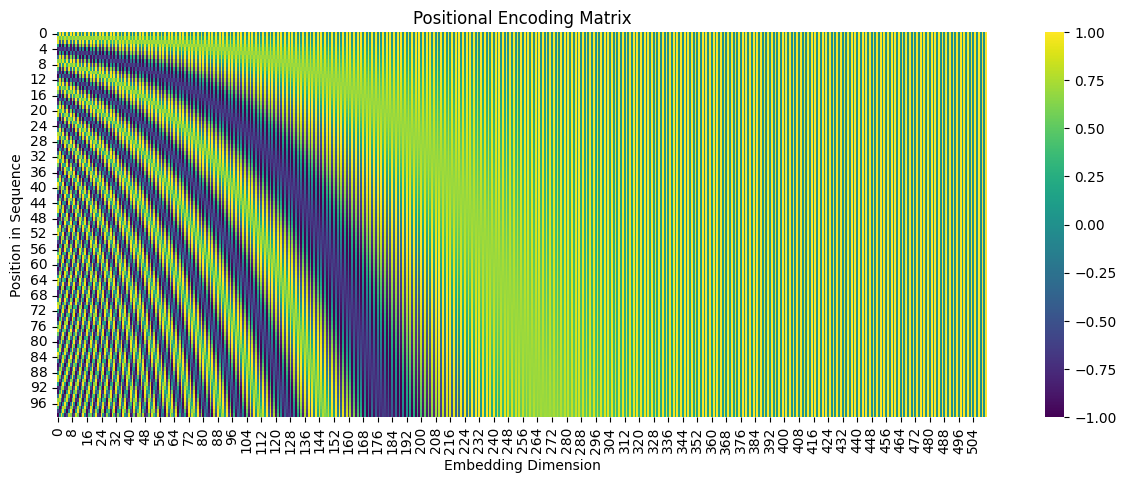

In [28]:
class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        #
        # Calculate the division term for the sine/cosine functions
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Calculate positional encodings for even and odd dimensions
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        #

        # Reshape for broadcasting and register as a buffer (not a model parameter)
        pe = pe.unsqueeze(0) # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """Adds positional encoding to the input tensor."""
        # x shape: (batch_size, seq_len, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# Visualize the positional encoding matrix
pe_module = SinusoidalPositionalEncoding(d_model=512)
pe_matrix = pe_module.pe.squeeze().numpy()

plt.figure(figsize=(15, 5))
sns.heatmap(pe_matrix[:100], cmap='viridis')
plt.xlabel("Embedding Dimension")
plt.ylabel("Position in Sequence")
plt.title("Positional Encoding Matrix")
plt.show()


#### Alternative 1: Learnable Positional Embeddings

The simplest alternative is to treat positions as discrete tokens and learn an embedding vector for each one, similar to word embeddings. This is implemented using `nn.Embedding`.


In [29]:
class LearnablePositionalEncoding(nn.Module):
    """Adds a trainable embedding vector for each absolute position."""
    def __init__(self, d_model: int, max_len: int = 5000, dropout: float = 0.1):
        super().__init__()
        self.pos_embedding = nn.Embedding(max_len, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """x has shape (batch, seq, d)"""
        seq_len = x.size(1)
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0)
        pos_emb = self.pos_embedding(positions)
        return self.dropout(x + pos_emb)




#### Alternative 2: Rotary Positional Encoding (RoPE)

A more modern and powerful technique is RoPE. Instead of *adding* a vector, RoPE **rotates** pairs of features in the Query and Key vectors based on their absolute position. The key insight is that the dot product of two rotated vectors depends only on their *relative* position.

For a 2D vector $[x_1, x_2]$ at position $m$ rotated by angle $m\theta$, we get:

$$ R_m \begin{pmatrix} x_1 \\ x_2 \end{pmatrix} = \begin{pmatrix} \cos(m\theta) & -\sin(m\theta) \\ \sin(m\theta) & \cos(m\theta) \end{pmatrix} \begin{pmatrix} x_1 \\ x_2 \end{pmatrix} $$

This is applied to pairs of dimensions $(x_{2i}, x_{2i+1})$ in Q and K. The dot product $q_m^T k_n$ then becomes a function of the relative position $m-n$. You do not need to implement this from scratch, but should understand the concept.


In [30]:
class RotaryPositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        assert d_model % 2 == 0, "RoPE needs even d_model so we can form (even, odd) pairs."
        self.d_model = d_model
        self.max_len = max_len

        # Same frequency schedule as sinusoidal PE
        inv_freq = 1.0 / (10000 ** (torch.arange(0, d_model, 2).float() / d_model))  # [d_model/2]
        pos = torch.arange(max_len, dtype=torch.float)  # [max_len]
        sinusoid_inp = torch.einsum("p,d->pd", pos, inv_freq)  # [max_len, d_model/2]

        self.register_buffer("cos", torch.cos(sinusoid_inp))  # [max_len, d/2]
        self.register_buffer("sin", torch.sin(sinusoid_inp))  # [max_len, d/2]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Rotate last-dim pairs (even, odd) according to position.

        Args:
            x: Tensor of shape (..., seq_len, d_model)

        Returns:
            Rotated tensor with the same shape as x.
        """
        assert x.size(-1) == self.d_model, "Last dim must equal d_model"
        B, seq_len, d = x.shape

        # Prepare cos/sin with broadcastable shape to x[..., 0::2]
        cos = self.cos[:seq_len, :].unsqueeze(0)  # [1, seq_len, d/2]
        sin = self.sin[:seq_len, :].unsqueeze(0)  # [1, seq_len, d/2]

        x_even = x[..., 0::2]  # (..., seq_len, d/2)
        x_odd  = x[..., 1::2]  # (..., seq_len, d/2)

        # [a;b] -> [a*cos - b*sin ; a*sin + b*cos]
        x_rot_even = x_even * cos - x_odd * sin
        x_rot_odd  = x_even * sin + x_odd * cos

        x_rot = torch.empty_like(x)
        x_rot[..., 0::2] = x_rot_even
        x_rot[..., 1::2] = x_rot_odd
        return x_rot



**Notes**

What is the primary advantage of RoPE over additive sinusoidal or learnable positional embeddings, especially for long sequences? The primary advantage of RoPE is its superior ability to **extrapolate to sequence lengths not seen during training**. Because the attention score inherently depends on the relative positions $(m-n)$, the model doesn't need to learn absolute positional meanings. The rotational mechanism naturally handles longer distances. In contrast, learnable embeddings cannot extrapolate at all, and while sinusoidal embeddings can, RoPE often does so more effectively.

Reference:
1. https://arxiv.org/abs/2104.09864




---
## The Architectural Pillars

Now we will assemble the core mechanisms into the larger **Encoder** and **Decoder** stacks. A key component is the residual "Add & Norm" connection.


#### Position-wise Feed-Forward Network

Implement the simple but crucial Position-wise Feed-Forward Network (FFN). This is applied to each position independently and consists of two linear layers with a ReLU (or GELU) activation in between.

$$\text{FFN}(x) = \text{Dropout}(\text{ReLU}(xW_1 + b_1))W_2 + b_2$$


In [31]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.activation = nn.ReLU() ## GELU  self.activation = nn.GELU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        #
        x = self.w_1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.w_2(x)
        #
        return x


# Test your implementation
ffn = PositionwiseFeedForward(d_model=512, d_ff=2048)
temp_x = torch.rand(1, 60, 512)
output = ffn(temp_x)
print("FFN Output shape:", output.shape)


FFN Output shape: torch.Size([1, 60, 512])


### The "Add & Norm" Step: Residuals and Layer Normalization

Before we combine the Multi-head attention (MHA) and FeedFordward (FFN), we need to know about some important components in (modern) transformers.
Each `sub-layer (like MHA or FFN)` in a Transformer block is wrapped in a residual connection followed by layer normalization.

-   **Residual Connection:** This is a simple skip connection: `output = sublayer(x) + x`.
-   **Layer Normalization:** This normalizes the features for each token *across the embedding dimension*. Unlike Batch Normalization, its calculations are independent of other examples in the batch, making it ideal for variable-length sequences.


### Pre-Norm vs. Post-Norm Architecture

The placement of Layer Normalization is a critical design choice:

-   **Post-Norm (Original):** `output = LayerNorm(x + Dropout(Sublayer(x)))`
    -   This was used in the original "Attention Is All You Need" paper.
    -   Can be difficult to train for very deep models without careful learning rate warmup, as gradients can vanish or explode.
-   **Pre-Norm (Modern Standard):** `output = x + Dropout(Sublayer(LayerNorm(x)))`
    -   This is more common today (e.g., in GPT models).
    -   It provides a "clean" residual path directly from the block's input to its output, leading to more stable gradients and often removing the need for learning rate warmup.



**Notes**

What's the benefit of residual connection ? Why is Layer Normalization generally preferred over Batch Normalization in Transformers?

> 1. Residual Connection allows gradients to flow directly through the network, which is critical for training very deep models by mitigating the vanishing gradient problem.
> 2. Batch Normalization computes statistics (mean/variance) across the batch dimension. This is problematic for sequence tasks where (1) sequence lengths can vary, making batch statistics unstable, and (2) at inference time (e.g., generating text token by token), the effective batch size is 1, making batch statistics meaningless. Layer Normalization computes statistics across the feature dimension for each item in the batch independently, avoiding these issues entirely.

Reference:
1. https://arxiv.org/abs/1512.03385
2. https://arxiv.org/abs/1607.06450
3. https://arxiv.org/abs/2002.04745



#### Encoder Layer

Combine the Multi-Head Attention and the FFN to create a full `EncoderLayer`. We will implement the **Post-Norm** and **Pre-Norm** version here.

An encoder layer always contains 3 key parts:

1. Multi-Head Attention (MHA)
2. Position-wise Feed-Forward Network (FFN)
3. Layer Normalization + Residual connections


Two possible architectures:
1. Pre-Norm Transformer. LayerNorm is applied BEFORE each block.
    - `x = x + Dropout(MHA(LayerNorm(x)))`
    - `x = x + Dropout(FFN(LayerNorm(x)))`


2. Post-Norm Transformer (original paper): LayerNorm is applied AFTER the residual connection.
    - `x = LayerNorm(x + Dropout(MHA(x)))`
    - `x = LayerNorm(x + Dropout(FFN(x)))`
    


In [32]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1,pre_norm=False):
        super().__init__()
        self.pre_norm = pre_norm
        #
        # Define: MultiHeadAttention(mha), PositionwiseFeedForward(ffn), Two Layernorm, Two Dropout
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        #

    def prenorm_forward(self, x, mask):
        ### output = x + dropout(mha(layernorm(x)))
        attn_input = self.norm1(x)
        attn_output, attention_weights_block1 = self.mha(attn_input, attn_input, attn_input, mask)
        out1 = x + self.dropout1(attn_output)

        ### output = x + dropout(ffn(layernorm(x)))
        ffn_input = self.norm2(out1)
        ffn_output = self.ffn(ffn_input)
        out2 = out1 + self.dropout2(ffn_output)
        return out2,attention_weights_block1

    def postnorm_forward(self, x, mask):

        ### output = LayerNorm(x + dropout(mha(layernorm(x))))
        attn_output, attention_weights_block1 = self.mha(x, x, x, mask)
        out1 = self.norm1(x + self.dropout1(attn_output))


        ### output = LayerNorm(x + dropout(ffn(layernorm(x))))
        ffn_output = self.ffn(out1)
        out2 = self.norm2(out1 + self.dropout2(ffn_output))
        return out2,attention_weights_block1

    def forward(self, x, mask):
        if self.pre_norm:
            return self.prenorm_forward(x, mask)
        else:
            return self.postnorm_forward(x, mask)


#### Decoder Layer

The `DecoderLayer` is similar but has three sub-layers:

1.  **Masked Multi-Head Self-Attention:** Self-attention on the decoder's own output, with a causal mask to prevent attending to future tokens.
2.  **Multi-Head Cross-Attention:** Queries from the decoder, but Keys & Values from the encoder's final output. This is how the decoder incorporates information from the source sequence.
3.  **Position-wise Feed-Forward Network.**


You will find 2 different masks:

1. Look-Ahead Mask (for decoder self-attention)
    - The look-ahead mask is used in the decoder’s self-attention to prevent a token from “seeing the future.”
    - When generating the output sequence, the decoder should only attend to:
        - previous tokens
	    - the current token
    but not to any tokens that come later.
2. Memory Mask (for encoder–decoder cross-attention)
    - The memory mask is used in the cross-attention between the decoder and the encoder outputs.

    - It prevents the decoder from attending to invalid encoder positions, such as:
	    - padding tokens
	    - empty positions
	    - any tokens we want to explicitly ignore


In [33]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1, pre_norm=False, use_cross_attention=True):
        super().__init__()
        #
        # Define: Two MultiHeadAttention one for self attetion , another for cross attention
        # Define: PositionwiseFeedForward
        # Define: Three layernorm, Three dropout
        self.pre_norm = pre_norm
        self.use_cross_attention = use_cross_attention

        # Initialize MultiHeadAttention for self-attention
        self.self_mha = MultiHeadAttention(d_model, num_heads)
        # Initialize MultiHeadAttention for cross-attention (if used)
        self.cross_mha = MultiHeadAttention(d_model, num_heads) if use_cross_attention else None
        # Initialize PositionwiseFeedForward network
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)

        # Initialize three Layer Normalization layers
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)


        # Initialize three Dropout layers
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        #


    def prenorm_forward(self, x, encoder_output, look_ahead_mask, memory_mask):
        # --- self-attention block ---
        # Apply Layer Normalization to the input x
        x_norm = self.norm1(x)

        # Apply self-attention using the normalized input x_norm for Q, K, V
        attn_output, attn_weights_block1 = self.self_mha(x_norm, x_norm, x_norm, look_ahead_mask)

        # Apply dropout to the attention output
        attn_output = self.dropout1(attn_output)

        # Add the attention output to the original input (residual connection)
        out1 = x + attn_output


        # --- cross-attention block (optional) ---
        if self.use_cross_attention and encoder_output is not None:
            # Apply Layer Normalization to the output of the first sub-layer
            out1_norm = self.norm2(out1)
            # Apply cross-attention, using normalized decoder output for Q, and encoder output for K, V
            cross_attn_output, attn_weights_block2 = self.cross_mha(out1_norm, encoder_output, encoder_output, memory_mask)
            # Apply dropout to the cross-attention output
            cross_attn_output = self.dropout2(cross_attn_output)
            # Add the cross-attention output to the previous output (residual connection)
            out2 = out1 + cross_attn_output
        else:
            # skip cross-attention: just pass through
            out2 = out1
            attn_weights_block2 = None

        # --- FFN block ---
        # Apply Layer Normalization to the output of the cross-attention (or out1 if no cross-attention)
        out2_norm = self.norm3(out2)
        # Pass the normalized output through the FFN
        ffn_output = self.ffn(out2_norm)
        # Apply dropout to the FFN output
        ffn_output = self.dropout3(ffn_output)
        # Add the FFN output to the previous output (residual connection)
        out3 = out2 + ffn_output

        return out3, attn_weights_block1, attn_weights_block2

    def postnorm_forward(self, x, encoder_output, look_ahead_mask, memory_mask):
        # --- self-attention block ---
        # Apply self-attention
        attn_output, attn_weights_block1 = self.self_mha(x, x, x, look_ahead_mask)
        # Apply dropout to the attention output
        attn_output = self.dropout1(attn_output)
        # Add the attention output to the input (residual connection) and then apply Layer Normalization
        out1 = self.norm1(x + attn_output)

        # --- cross-attention block (optional) ---
        if self.use_cross_attention and encoder_output is not None:
            # Apply cross-attention
            cross_attn_output, attn_weights_block2 = self.cross_mha(out1, encoder_output, encoder_output, memory_mask)

            # Apply dropout to the cross-attention output
            cross_attn_output = self.dropout2(cross_attn_output)

            # Add the cross-attention output to the previous output (residual connection) and then apply Layer Normalization
            out2 = self.norm2(out1 + cross_attn_output)

        else:
            out2 = out1
            attn_weights_block2 = None

        # --- FFN block ---
        # Pass the output through the FFN
        ffn_output = self.ffn(out2)
        # Apply dropout to the FFN output
        ffn_output = self.dropout3(ffn_output)
        # Add the FFN output to the previous output (residual connection) and then apply Layer Normalization
        out3 = self.norm3(out2 + ffn_output)

        return out3, attn_weights_block1, attn_weights_block2

    def forward(self, x, encoder_output, look_ahead_mask, memory_mask):
        if self.pre_norm:
            return self.prenorm_forward(x, encoder_output, look_ahead_mask, memory_mask)
        else:
            return self.postnorm_forward(x, encoder_output, look_ahead_mask, memory_mask)


---
## Module 4: The Grand Unification and Applications

It's time to assemble the full model from the components you've built.


We will first define the `Encoder` and `Decoder` module for you, which are basically a stack of encoder layers and decoder layers.


### Decoder Only Language Model and Tiny Story




Let's first load a dataset that we want to train on. It's `TinyStory` where


In [34]:
from datasets import load_dataset
# This downloads and loads TinyStories; feel free to slice less/more data.
raw_ds = load_dataset("roneneldan/TinyStories", split="train[:1%]")  # ~1% for demo
texts = [ex["text"] for ex in raw_ds]
print("Number of stories:", len(texts))
max_length = 0
lengths_list = []
for text in texts:
    max_length = max(max_length, len(text))
    lengths_list.append(len(text))
print("Average length: ", sum(lengths_list) / len(lengths_list))
print("Example story:\n", texts[0][:300])


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004-2d5a1467fff108(…):   0%|          | 0.00/249M [00:00<?, ?B/s]

data/train-00001-of-00004-5852b56a2bd28f(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/train-00002-of-00004-a26307300439e9(…):   0%|          | 0.00/246M [00:00<?, ?B/s]

data/train-00003-of-00004-d243063613e5a0(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/validation-00000-of-00001-869c898b5(…):   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

Number of stories: 21197
Average length:  894.1183658064821
Example story:
 One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.

Lily went to her mom and said, "Mom, I found this needle. Can you share it with me and 


Neural networks (including Transformers) do not understand text directly, they only work with numbers (tensors).

For a translation model, we need a way to convert:

**human text (strings) ⟶ integer IDs ⟶ embeddings for the model**

This is exactly what a tokenizer does.



A tokenizer is a component that:
1. Splits text into tokens (small units like words, subwords, or characters)
2. Maps each token to an integer ID using a vocabulary
3. Can also decode integer IDs back to text


We build a basic word-level tokenizer:

- tokenization: split with a regex into words and punctuation

- build vocab from most frequent tokens

- map word ↔ id, including special tokens


In [35]:
# Tiny LM hyperparams (keep small for teaching / debugging)
VOCAB_SIZE_LIMIT = 8192          # max number of word types (excluding specials)
MAX_SEQ_LEN = 1024                # max tokens per story (after truncation)

PAD_TOKEN = "<pad>"
BOS_TOKEN = "<bos>"
EOS_TOKEN = "<eos>"
UNK_TOKEN = "<unk>"


def basic_tokenize(text: str):
    """
    Word-level tokenizer with punctuation kept as separate tokens.
    Example: "Lily's ball." -> ["lily", "'", "s", "ball", "."]
    """
    text = text.lower()
    # split into words and punctuation
    return re.findall(r"\w+|[^\w\s]", text)


def build_vocab(texts, vocab_size_limit, min_freq=2):
    counter = Counter()
    for t in texts:
        counter.update(basic_tokenize(t))

    # Reserve slots for special tokens
    specials = [PAD_TOKEN, BOS_TOKEN, EOS_TOKEN, UNK_TOKEN]

    # Most common tokens above min_freq
    most_common = [
        tok for tok, freq in counter.most_common()
        if freq >= min_freq and tok not in specials
    ]
    print("Total Common Words: ", len(most_common))

    most_common = most_common[: vocab_size_limit - len(specials)]
    print(f"We will keep {len(most_common)} words")

    itos = specials + most_common
    stoi = {tok: i for i, tok in enumerate(itos)}

    return stoi, itos



In [36]:
stoi, itos = build_vocab(texts, VOCAB_SIZE_LIMIT)
vocab_size = len(itos)
print("Vocab size:", vocab_size)

pad_token_id = stoi[PAD_TOKEN]
bos_token_id = stoi[BOS_TOKEN]
eos_token_id = stoi[EOS_TOKEN]
unk_token_id = stoi[UNK_TOKEN]


Total Common Words:  8926
We will keep 8188 words
Vocab size: 8192


In [37]:
class WordTokenizer:
    def __init__(self, stoi, itos, bos_id, eos_id, unk_id):
        self.stoi = stoi
        self.itos = itos
        self.bos_id = bos_id
        self.eos_id = eos_id
        self.unk_id = unk_id

    def encode(self, text, add_special_tokens=True):
        tokens = basic_tokenize(text)
        ids = [self.stoi.get(tok, self.unk_id) for tok in tokens]
        if add_special_tokens:
            return [self.bos_id] + ids + [self.eos_id]
        return ids

    def decode(self, ids, skip_special_tokens=True):
        toks = []
        for i in ids:
            if i < 0 or i >= len(self.itos):
                continue
            tok = self.itos[i]
            if skip_special_tokens and tok in {PAD_TOKEN, BOS_TOKEN, EOS_TOKEN}:
                continue
            toks.append(tok)
        # naive join: space between words, but no more processing
        return " ".join(toks)

tokenizer = WordTokenizer(stoi, itos, bos_token_id, eos_token_id, unk_token_id)
print("Encoded sample:", tokenizer.encode(texts[0])[:30])
print("Decoded back:", tokenizer.decode(tokenizer.encode(texts[0])[:30]))


Encoded sample: [1, 35, 26, 7, 9, 39, 58, 74, 21, 115, 9, 1903, 22, 16, 186, 4, 13, 162, 14, 11, 1384, 8, 47, 24, 14, 184, 14, 11, 863, 4]
Decoded back: one day , a little girl named lily found a needle in her room . she knew it was difficult to play with it because it was sharp .


In [38]:
class TinyStoriesWordDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        ids = self.tokenizer.encode(text, add_special_tokens=True)  # [BOS, ..., EOS]

        # truncate
        ids = ids[: self.max_len]

        # pad
        pad_len = self.max_len - len(ids)
        ids = ids + [pad_token_id] * pad_len

        ids = torch.tensor(ids, dtype=torch.long)  # (T,)

        # LM: predict token t+1 from tokens <= t
        input_ids = ids[:-1]   # (T-1)
        labels    = ids[1:]    # (T-1)

        return input_ids, labels



In this part, you will implement two helper functions that create **boolean masks** for our Transformer:

1. `create_padding_mask`
2. `create_look_ahead_mask`

These masks will later be used in **multi-head attention** to tell the model:
- which positions are **padding** and should be ignored
- which positions are in the **future** and should not be visible to the decoder (causal masking)


In [39]:
def create_padding_mask(seq: torch.Tensor, pad_token_id: int) -> torch.Tensor:
    """
    seq: (batch_size, seq_len)
    Returns:
        pad_mask: (batch_size, seq_len) bool
        True  = this position is PAD and should be masked out
        False = normal token
    """
    return (seq == pad_token_id)


def create_look_ahead_mask(size: int, device=None) -> torch.Tensor:
    """
    size: target sequence length
    Returns:
        look_ahead: (size, size) bool upper-triangular mask.
        look_ahead[i, j] = True  if j > i  (future position, should be masked)
                           False otherwise
    """
    mask = torch.triu(torch.ones(size, size, dtype=torch.bool), diagonal=1)

    if device is not None:
        mask = mask.to(device)
    return mask  # (size, size)


We build the `DecoderOnlyLM` for you here, and you are encouraged to read the code.


In [40]:
class DecoderOnlyLM(nn.Module):
    def __init__(
        self,
        vocab_size,
        num_layers,
        d_model,
        num_heads,
        d_ff,
        max_seq_len,
        pad_token_id,
        dropout=0.1,
        pre_norm=True,
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.pad_token_id = pad_token_id
        self.max_seq_len = max_seq_len

        # token + learned position embeddings
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(max_seq_len, d_model)
        self.dropout = nn.Dropout(dropout)

        # reuse your DecoderLayer, but disable cross-attention
        self.layers = nn.ModuleList([
            DecoderLayer(
                d_model=d_model,
                num_heads=num_heads,
                d_ff=d_ff,
                dropout=dropout,
                pre_norm=pre_norm,
                use_cross_attention=False,   # <- important
            )
            for _ in range(num_layers)
        ])

        self.final_ln = nn.LayerNorm(d_model, eps=1e-6)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)

    def forward(self, input_ids):
        """
        input_ids: (B, T)
        We train it as a language model: predict token t+1 from tokens <= t.
        """
        B, T = input_ids.shape
        device = input_ids.device

        # --- build self-attention mask: (B, T, T), True = masked ---
        pad_mask = create_padding_mask(input_ids, self.pad_token_id)     # (B, T)
        look_ahead = create_look_ahead_mask(T, device=device)            # (T, T)
        look_ahead = look_ahead.unsqueeze(0).expand(B, -1, -1)           # (B, T, T)
        pad_2d = pad_mask.unsqueeze(1).expand(-1, T, -1)                 # (B, T, T)
        self_mask = torch.logical_or(look_ahead, pad_2d)                 # (B, T, T)

        # --- embeddings ---
        pos_ids = torch.arange(T, device=device).unsqueeze(0).expand(B, T)
        x = self.token_emb(input_ids) + self.pos_emb(pos_ids)
        x = x * math.sqrt(self.d_model)
        x = self.dropout(x)

        all_attn = {}
        # Note: encoder_output=None, memory_mask=None for decoder-only
        for i, layer in enumerate(self.layers):
            x, attn_self, attn_cross = layer(
                x,
                encoder_output=None,
                look_ahead_mask=self_mask,
                memory_mask=None,
            )
            all_attn[f"layer_{i+1}_self"] = attn_self  # cross is None in this mode

        x = self.final_ln(x)
        logits = self.lm_head(x)   # (B, T, vocab_size)
        return logits, all_attn


Feel free to change the parameters for your Language Model. **The training will take some time.**


In [41]:

NUM_LAYERS = 6
D_MODEL = 256
DROPOUT = 0.1
NUM_HEADS = 8
PRE_NORM = True
D_FF = 768
model = DecoderOnlyLM(
    vocab_size=vocab_size,
    num_layers=NUM_LAYERS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    d_ff=D_FF,
    max_seq_len=MAX_SEQ_LEN - 1,  # dataset gives length T-1
    pad_token_id=pad_token_id,
    dropout=DROPOUT,
    pre_norm=PRE_NORM,
).to(device)

sum(p.numel() for p in model.parameters()) / 1e6, "M params"
model = torch.compile(model)


In [ ]:
BATCH_SIZE = 32
LR = 0.001
NUM_EPOCHS = 30
train_dataset = TinyStoriesWordDataset(texts, tokenizer, MAX_SEQ_LEN)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
len(train_loader)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(ignore_index=pad_token_id)

model.train()
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    for input_ids, labels in pbar:
        input_ids = input_ids.to(device)   # (B, T)
        labels = labels.to(device)         # (B, T)

        optimizer.zero_grad()
        logits, _ = model(input_ids)       # (B, T, V)

        B, T, V = logits.shape
        loss = criterion(
            logits.view(B * T, V),
            labels.view(B * T),
        )

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix(loss=running_loss / (pbar.n or 1))

    print(f"Epoch {epoch+1} average loss: {running_loss / len(train_loader):.4f}")


Here we provide you the function to generate story. **You can provide your own prompt and to play with your "Story-GPT"**


In [42]:
@torch.no_grad()
def generate_story(model, tokenizer, prompt, max_new_tokens=50):
    model.eval()
    # Encode prompt without EOS; we will add BOS at the front
    prompt_ids = tokenizer.encode(prompt, add_special_tokens=False)
    # Add BOS
    input_ids = [bos_token_id] + prompt_ids
    # Truncate if too long
    input_ids = torch.tensor(input_ids, dtype=torch.long, device=device).unsqueeze(0)  # (1, T0)

    for _ in range(max_new_tokens):
        logits, _ = model(input_ids)               # (1, T, V)
        next_logits = logits[:, -1, :]            # (1, V)
        next_id = torch.argmax(next_logits, dim=-1)  # (1,)

        # Append
        input_ids = torch.cat([input_ids, next_id.unsqueeze(1)], dim=1)

        # Optional early stop on EOS
        if next_id.item() == eos_token_id:
            break

    # Drop BOS and anything after EOS
    generated_ids = input_ids[0].tolist()
    return tokenizer.decode(generated_ids, skip_special_tokens=True)


In [43]:
prompt = "Once upon a day."
story = generate_story(model, tokenizer, prompt, max_new_tokens=500)
print("PROMPT:", prompt)
print("STORY:", story)


/usr/local/lib/python3.12/dist-packages/torch/backends/cuda/__init__.py:131: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  return torch._C._get_cublas_allow_tf32()
/usr/local/lib/python3.12/dist-packages/torch/_inductor/compile_fx.py:312: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/_inductor/lowering.

PROMPT: Once upon a day.
STORY: once upon a day . sat tight chains freezing separated forts œok ayla flame weightless pillow dent tick jessi encourage rinsed myself thanked toughest asked climbing shown mechanic blocks yacht or hen ago parrot veggies shovel improvement tore beauty souvenirs celi tied afraid fairly casting hears sheets figures sandstorm pushing brought kneels mice canvas bessy whenever reader bolt seaweed crabby zebra curious patiently sharin confused relief food advice wonders recommend scarf backpack rocked opera temperatures mysterious minnie bubbly painter honeyâ visit waddled nina springs opera alex shaded spread enchanted suns stern onwards keeping points bridge ancient debby icicle ocean maureen hunts zero - bath wires power counting fur alfred zigzagging hatch copper wilson dish tires fifteen park tightly pizza oil springtime trimmed vases wee stretches toto repairing grow pawn escaping flutter faraway marcia says blue moms rope foxes bike œi gill œthank layer b

### Encoder-only classification

For classification tasks such as sentence classification, the goal is to understand the input sequence rather than generate a new one. In these cases, we can use only the Encoder component of the Transformer. The encoder’s final output is typically aggregated (e.g., by averaging all token representations) and then fed into a simple linear classifier.

Encoder-only Transformer on nucleotide sequences.


In [44]:
import gdown
import os
import pandas as pd
from sklearn.model_selection import train_test_split
!mkdir data
!gdown 19zqlrBt8DIdBDt68Ja5n-yTh4-u3Ef-k -O data/train_data.csv --quiet
!gdown 1l5z0DgjhBxWhorn2lkFbblfHlinI_Pfu -O data/test_data.csv --quiet

train_csv_path = 'data/train_data.csv'
train_df = pd.read_csv(train_csv_path)

# Extract sequences and labels
all_sequences = train_df['sequences'].tolist()
all_labels = train_df['labels'].tolist()


# Split into training and validation sets
train_x, val_x, train_y, val_y = train_test_split(
    all_sequences, all_labels, test_size=0.1, random_state=42, stratify=all_labels
)

print(f"Train size: {len(train_x)}, Validation size: {len(val_x)}")
print("Example sequence:")
print(train_x[0])


mkdir: cannot create directory ‘data’: File exists
Train size: 27000, Validation size: 3000
Example sequence:
GTCCCTGCCCTGTCCGGAGCCCTCCCTCAGCCCTGGGCTCACCTGGAATAAAAGCTGAAGTCCTCGCCCTCGTTGTCTGTCTGACCTCGCCTCTCCTGCATGCCTACTCATGCTCACGCCCTCATCACTGCCCGTGGTCCCTGAGGCGCCCACGTGATTCTGCCTCAGGACCATTGCATGTCCTCCTCCTTCTGCCTGGAGCCCGCTCTCCTGGGGTGGCCACATTGCTGCTCCCCTTACCTCCTGCACATCCTGTATGTACCCCAGCCCTCCCCAACCCATTCTTGGCATCCTTGCCCTCATCTTCTCCTCGGGACGCTGTCTCTTGGTTCAGGGTCTGACTCCTGCCGGTAGAACGTGAGCTCTGGGAGAGCAGGGATGACTTCCTCACTCCCAGCAC


Similarily, we need to build a tokenizer for sequential data of DNA.

The following tokenizer is simple (maybe too simple), we map "A","C","G" and "T" to 0,1,2 and 3. We also add an extra helper token `[cls]`, which we add it on the head of the sentence to summarize the whole input for classification.

**You are encouraged to design your own**.


In [45]:

########################################
# 1. Simple DNA tokenizer: A, C, G, T, cls_token
########################################
class DNATokenizer:
    """
    Tokenizer for DNA with 4 bases + a [CLS] token:
      A, C, G, T, [CLS]
    Sequences contain only A/C/G/T; [CLS] is added by the dataset.
    """
    def __init__(self):
        self.cls_token = "[CLS]"

        self.vocab = {
            "A": 0,
            "C": 1,
            "G": 2,
            "T": 3,
            self.cls_token: 4,
        }
        self.id2token = {i: t for t, i in self.vocab.items()}
        self.vocab_size = len(self.vocab)

        self.cls_token_id = self.vocab[self.cls_token]

    def encode(self, seq: str) -> torch.Tensor:
        """
        Encode a DNA sequence string (A/C/G/T only) to a 1D tensor of token ids.
        Note: this does NOT add [CLS]; the dataset will prepend it.
        """
        ids = [self.vocab[ch] for ch in seq.strip().upper()]
        return torch.tensor(ids, dtype=torch.long)

    def decode(self, ids: List[int]) -> str:
        """
        Decode ids back to a DNA string (ignoring [CLS]).
        """
        tokens = []
        for i in ids:
            tok = self.id2token[int(i)]
            if tok == self.cls_token:
                continue
            tokens.append(tok)
        return "".join(tokens)
class DNADataset(Dataset):
    """
    Holds DNA sequences (all same length) and labels (0/1).
    We prepend a [CLS] token to each sequence.
    """
    def __init__(self, sequences: List[str], labels: List[int], tokenizer: DNATokenizer):
        assert len(sequences) == len(labels)
        self.sequences = sequences
        self.labels = labels
        self.tokenizer = tokenizer

        # sanity check: all sequences same length
        Ls = {len(s) for s in sequences}
        assert len(Ls) == 1, f"Sequences must all have same length, got lengths: {Ls}"
        base_len = Ls.pop()
        # +1 for CLS position at the beginning
        self.seq_len = base_len + 1

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx) -> Tuple[torch.Tensor, int]:
        seq = self.sequences[idx]
        label = int(self.labels[idx])

        # encode bases
        token_ids = self.tokenizer.encode(seq)  # (L,)

        # prepend [CLS] token
        cls_id = torch.tensor([self.tokenizer.cls_token_id], dtype=torch.long)
        token_ids = torch.cat([cls_id, token_ids], dim=0)  # (L+1,)

        return token_ids, label


Here we define an encoder which consists of a positional embedding and a stack of encoder layer.


In [46]:

class Encoder(nn.Module):
    """
    Transformer encoder stack:
    - positional encoding
    - N x EncoderLayer
    We don't use masks here (no padding).
    """
    def __init__(self, num_layers, d_model, num_heads, d_ff,
                 max_seq_len, dropout=0.1, pre_norm=True,):
        super().__init__()
        self.pos_encoding = SinusoidalPositionalEncoding(d_model, max_len=max_seq_len, dropout=dropout)
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout=dropout, pre_norm=pre_norm)
            for _ in range(num_layers)
        ])

    def forward(self, x: torch.Tensor):
        """
        x: (B, T, d_model)
        Returns:
            x: (B, T, d_model)
            attn_weights: dict of layer -> attention map
        """
        x = self.pos_encoding(x)
        attn_weights = {}
        mask = None  # no padding / no special masking
        for i, layer in enumerate(self.layers):
            x, attn = layer(x, mask)
            attn_weights[f"encoder_layer_{i+1}"] = attn
        return x, attn_weights


In [47]:
class DNAEnhancerTransformer(nn.Module):
    """
    Encoder-only Transformer for enhancer classification.

    Pipeline:
      input_ids (with [CLS]) -> token embedding
                              -> positional encoding + encoder stack
                              -> take hidden state at [CLS] position (index 0)
                              -> LayerNorm + Dropout + Linear classifier
    """
    def __init__(
        self,
        vocab_size: int,
        seq_len: int,
        d_model: int = 128,
        num_heads: int = 4,
        d_ff: int = 256,
        num_layers: int = 2,
        num_classes: int = 2,
        dropout: float = 0.1,
        pre_norm: bool = True,
    ):
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len

        self.token_emb = nn.Embedding(vocab_size, d_model)

        self.encoder = Encoder(
            num_layers=num_layers,
            d_model=d_model,
            num_heads=num_heads,
            d_ff=d_ff,
            max_seq_len=seq_len,
            dropout=dropout,
            pre_norm=pre_norm,
        )

        self.dropout = nn.Dropout(dropout)
        self.final_ln = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, input_ids: torch.Tensor):
        """
        input_ids: (B, T) — includes [CLS] at position 0
        Returns:
            logits: (B, num_classes)
            attn_weights: dict
        """
        # 1) token embedding
        x = self.token_emb(input_ids)          # (B, T, d_model)
        x = x * math.sqrt(self.d_model)

        # 2) encoder stack
        x, attn_weights = self.encoder(x)      # (B, T, d_model)

        # 3) use [CLS] representation at position 0
        cls_repr = x[:, 0, :]                  # (B, d_model)

        # 4) LayerNorm + dropout + classifier
        cls_repr = self.final_ln(cls_repr)
        cls_repr = self.dropout(cls_repr)
        logits = self.classifier(cls_repr)     # (B, num_classes)

        return logits, attn_weights


In [48]:

# 5.1 Create tokenizer
tokenizer = DNATokenizer()

train_dataset = DNADataset(train_x, train_y, tokenizer)
val_dataset = DNADataset(val_x, val_y, tokenizer)

seq_len = train_dataset.seq_len
print("Sequence length:", seq_len)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)



Sequence length: 401


In [49]:
# 5.3 Build model, loss, optimizer

print("Using device:", device)
NUM_LAYERS = 4
D_MODEL = 128
DROPOUT = 0.0
NUM_HEADS = 4
PRE_NORM = True
D_FF = 256

model = DNAEnhancerTransformer(
    vocab_size=tokenizer.vocab_size,
    seq_len=seq_len,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    d_ff=D_FF,
    num_layers=NUM_LAYERS,
    num_classes=2,
    dropout=DROPOUT,
    pre_norm=PRE_NORM,
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)

########################################
# 6. Training / evaluation loops
########################################

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for input_ids, labels in loader:
        input_ids = input_ids.to(device)  # (B, T)
        labels = labels.to(device)        # (B,)

        optimizer.zero_grad()
        logits, _ = model(input_ids)      # (B, num_classes)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * input_ids.size(0)
        preds = logits.argmax(dim=-1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total if total > 0 else 0.0
    acc = correct / total if total > 0 else 0.0
    return avg_loss, acc


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    for input_ids, labels in loader:
        input_ids = input_ids.to(device)
        labels = labels.to(device)

        logits, _ = model(input_ids)
        loss = criterion(logits, labels)

        total_loss += loss.item() * input_ids.size(0)
        preds = logits.argmax(dim=-1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total if total > 0 else 0.0
    acc = correct / total if total > 0 else 0.0
    return avg_loss, acc


num_epochs = 10  # increase for real training

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    print(
        f"Epoch {epoch:02d} | "
        f"Train loss: {train_loss:.4f}, acc: {train_acc*100:.2f}% | "
        f"Val loss: {val_loss:.4f}, acc: {val_acc*100:.2f}%"
    )


Using device: cuda
Epoch 01 | Train loss: 0.6482, acc: 61.27% | Val loss: 0.6299, acc: 64.07%
Epoch 02 | Train loss: 0.6358, acc: 62.97% | Val loss: 0.6395, acc: 61.17%
Epoch 03 | Train loss: 0.6360, acc: 63.18% | Val loss: 0.6270, acc: 63.83%
Epoch 04 | Train loss: 0.6343, acc: 63.26% | Val loss: 0.6235, acc: 64.57%
Epoch 05 | Train loss: 0.6329, acc: 63.38% | Val loss: 0.6222, acc: 64.63%
Epoch 06 | Train loss: 0.6296, acc: 63.55% | Val loss: 0.6137, acc: 65.63%
Epoch 07 | Train loss: 0.6234, acc: 64.29% | Val loss: 0.6169, acc: 65.93%
Epoch 08 | Train loss: 0.6221, acc: 64.51% | Val loss: 0.6157, acc: 66.03%
Epoch 09 | Train loss: 0.6207, acc: 64.32% | Val loss: 0.6126, acc: 65.70%
Epoch 10 | Train loss: 0.6210, acc: 64.39% | Val loss: 0.6114, acc: 66.07%


In [50]:
test_csv_path = 'data/test_data.csv'
test_df = pd.read_csv(test_csv_path)
# Extract sequences and labels
test_sequences = test_df['sequences'].tolist()
print("Length of Test Data: ", len(test_sequences))
test_labels = [0 for _ in range(len(test_sequences))]
test_data = DNADataset(test_sequences, test_labels, tokenizer)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

model.eval()

predictions = []
ids = []
with torch.no_grad():
    for i,(input_ids, _) in enumerate(test_loader):
        input_ids = input_ids.to(device)  # (B, T)
        logits, _ = model(input_ids)      # (B, num_classes)
        _, predicted = torch.max(logits, 1)
        predictions.extend(predicted.cpu().numpy())
        # Generate IDs for each sample
        batch_ids = list(range(i * test_loader.batch_size, i * test_loader.batch_size + len(input_ids)))
        ids.extend(batch_ids)


Length of Test Data:  3000


In [51]:
with open("homework_baseline.csv", "w") as f:
    f.write("ID,label\n")  # Write header
    for i, label in enumerate(predictions, start=0):
        f.write(f"{i},{label}\n")  # Write ID and label


**Transformer result:** accuracy **0.72444** 